# Imports 

In [22]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 

import os
import sys
import struct
import time
import pandas as pd

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm
import nibabel as nib

%matplotlib inline

In [2]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"

DEVICE = 'cpu'

# Exploring K matrix 

In [3]:
K_subj1_v1 = np.load(DATA_PATH+"/K_mat_subj1_v1.npy.npz")

In [4]:
K_subj1_v1 = K_subj1_v1['arr_0']

In [5]:
K_subj1_v1


array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [4.02972366e-274, 8.19587951e-273, 1.64829062e-271, ...,
        7.70625732e-187, 1.36435445e-187, 2.38851976e-188],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [2.50891688e-062, 4.76338731e-062, 9.01616609e-062, ...,
        3.48151563e-064, 1.82655719e-064, 9.55376576e-065],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.45255300e-321, 4.44659081e-323, 0.00000000e+000]])

# Exploring betas (GLM fit)
For Subject = 1, Session = 1

In [6]:
BETAS_PATH = NSD_ROOT+"/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/"

In [7]:
beta_file = BETAS_PATH + 'betas_session01.hdf5'

In [8]:
beta_file_s1 = h5py.File(beta_file, 'r')

for key, value in beta_file_s1.items() :
    print(key,": \n", value,"\n")

betas : 
 <HDF5 dataset "betas": shape (750, 83, 104, 81), type "<i2"> 



In [9]:
betas = np.asarray(beta_file_s1['betas'])

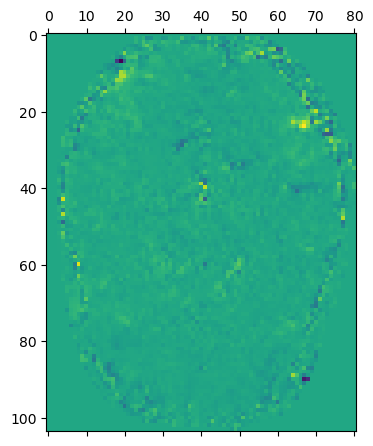

In [10]:
plt.matshow(betas[350, 42, ...]);

In [12]:
betas_nii = nib.load(BETAS_PATH + 'betas_session01.nii.gz').get_fdata()

In [13]:
betas_nii = betas_nii.transpose(3, 2, 1, 0)

In [14]:
betas_nii.shape

(750, 83, 104, 81)

In [15]:
betas.shape

(750, 83, 104, 81)

In [16]:
np.array_equal(betas_nii, betas)

True

In [18]:
img = nib.load(BETAS_PATH + 'betas_session01.nii.gz')

In [19]:
header = img.header

In [20]:
print(img.shape)
print(header.get_zooms()) # Sampling rate of 1.33 seconds

(81, 104, 83, 750)
(1.8, 1.8, 1.8, 1.3333334)


In [21]:
img_data = img.get_fdata()

In [22]:
print(img_data.shape)

(81, 104, 83, 750)


In [23]:
mid_slice_x = img_data[15, :, :,:]
print(mid_slice_x.shape)

(104, 83, 750)


Shape of slice: (104, 83)


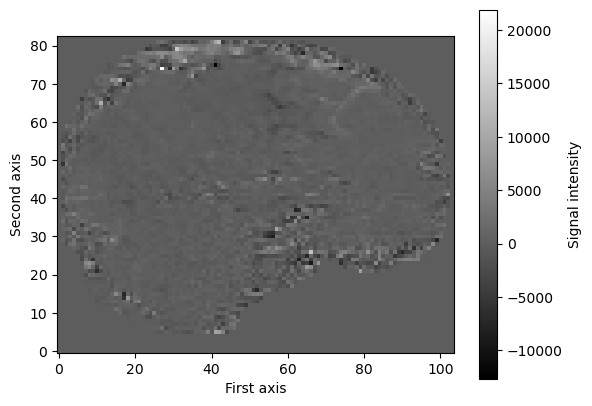

In [24]:
mid_slice_x_fmri = img_data[39, :, :, 0]  # x = 39, t = 0
print("Shape of slice: %s" % (mid_slice_x_fmri.shape,))

plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()


In [25]:
mid_vox_ts = img_data[55, 55, 20, :]  
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))

Voxel timeseries shape: (750,)


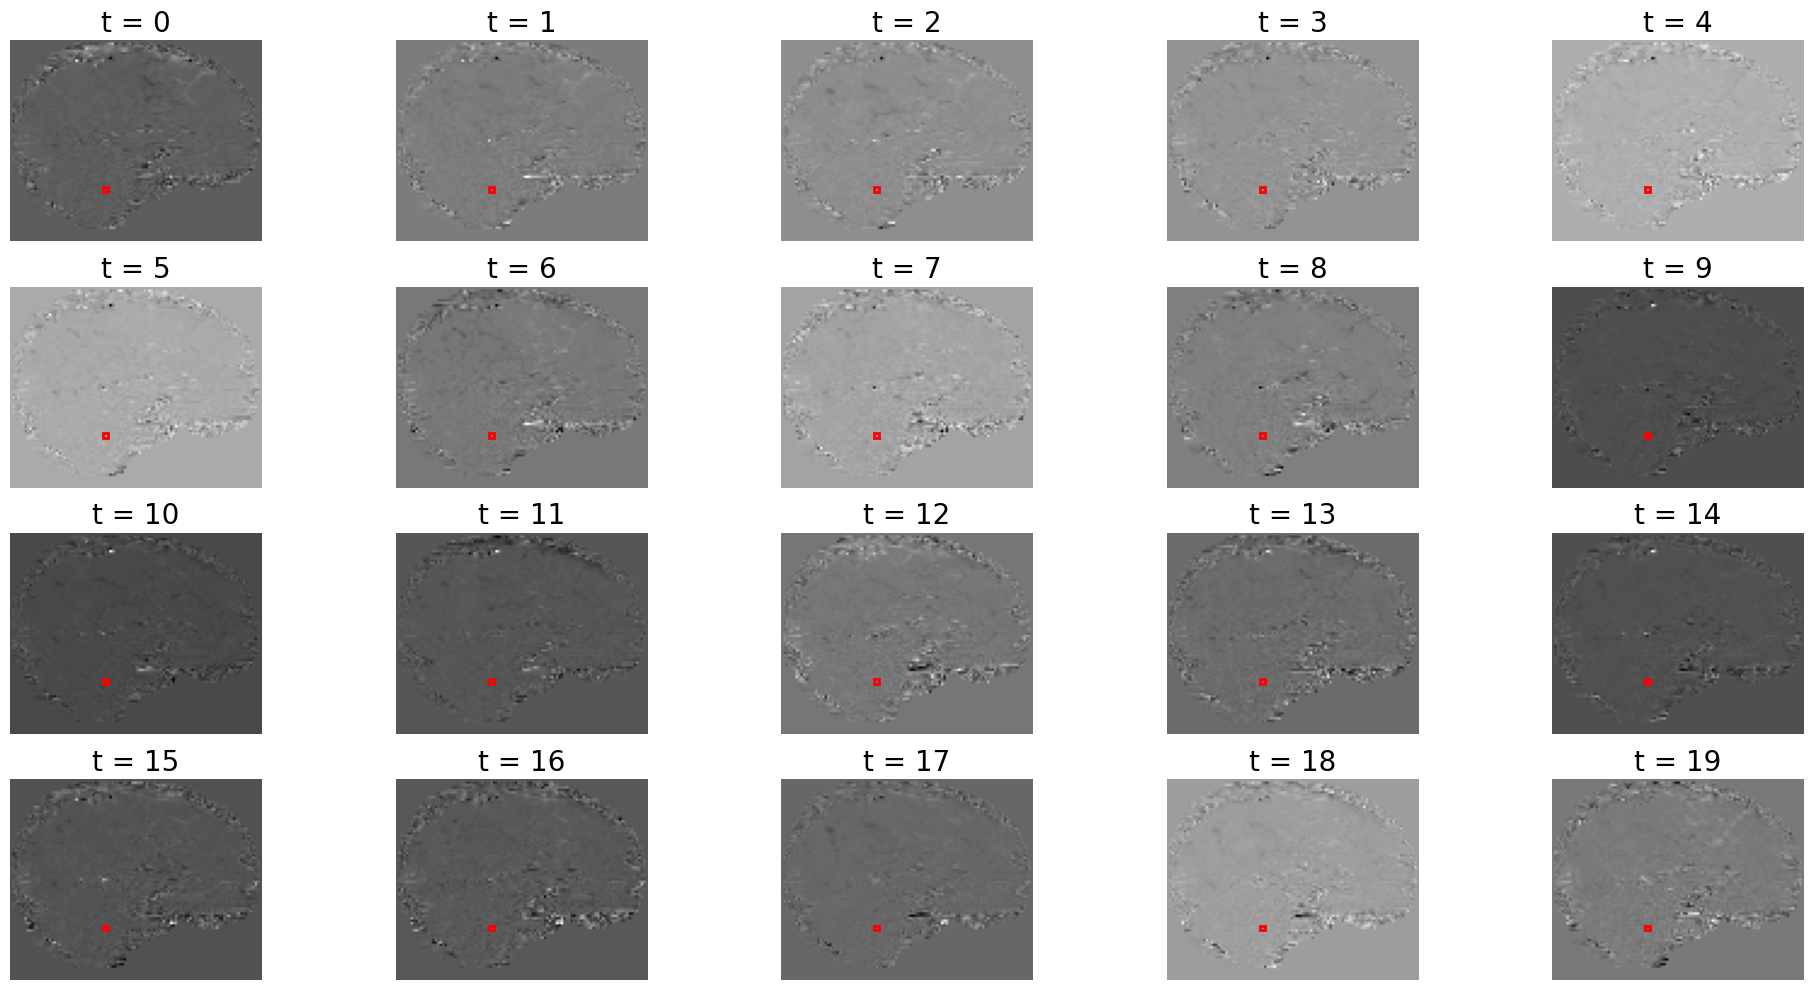

In [27]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(20, 10))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(img_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()

# Load the Image stimuli shown in NSD

There are two types:  73,000 and 10,000

In [8]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data_73k = np.copy(image_data_set['imgBrick'])
image_data_set.close()

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



In [9]:
stiminfo = pd.read_pickle(nsd_stiminfo_file)

subject=1

image_data_set_10k = h5py.File(STIM_ROOT + "S%d_stimuli_227.h5py"%subject, 'r') # For example - S01_stimuli_227.h5py
image_data_10k = np.copy(image_data_set_10k['stimuli'])
image_data_set_10k.close()

print (image_data_10k.shape) # Orig. 10,000 x 3 x 227 x 227
print (image_data_10k.dtype)
print (np.min(image_data_10k[0]), np.max(image_data_10k[0]))

(10000, 3, 227, 227)
uint8
0 255


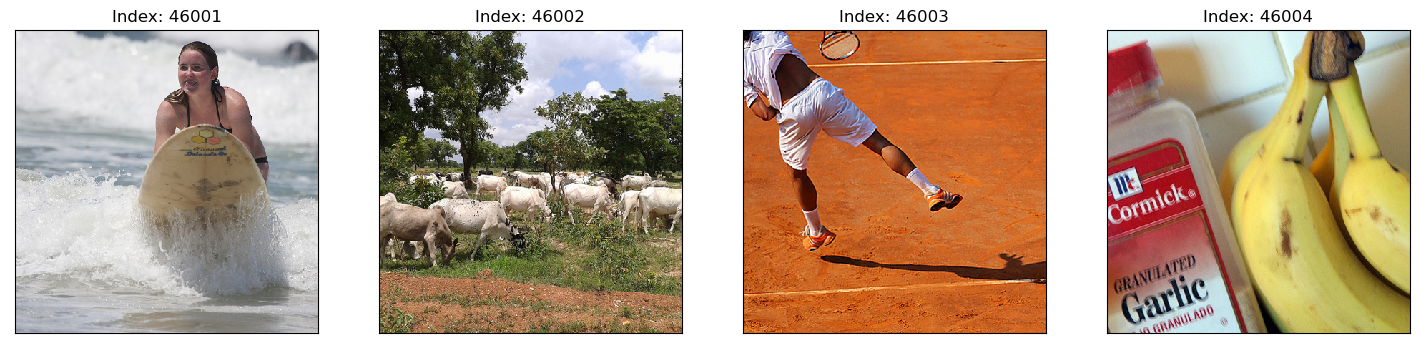

In [11]:
plt.figure(figsize=(18,6))

num_images = 4 
for i in range(num_images):
    plt.subplot(1,num_images,i+1)
    plt.imshow(image_data_73k[i+46001], cmap='gray', interpolation='None')
    plt.title(f"Index: {i+46001}")
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

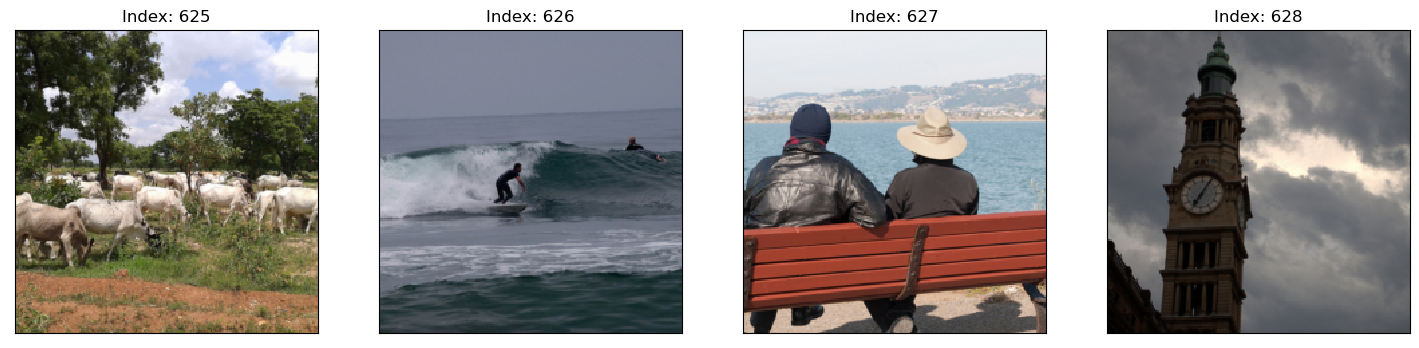

In [12]:
plt.figure(figsize=(18,6))

num_images = 4 
for i in range(num_images):
    
    plt.subplot(1,num_images,i+1)
    plt.imshow(image_data_10k[i+625].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.title(f"Index: {i+625}")
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Mask the betas for the relevant ROIs
For V1, V2, V3, V4

In [14]:
import nilearn
from nilearn import image
from nilearn import plotting 
from nilearn.image import math_img

from pathlib import Path
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker

In [37]:
ROI_PATH = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/ppdata/'

In [38]:
v1_mask_img= image.load_img("../data/v1_mask_img.nii")
v1_masker = NiftiMasker(mask_img = v1_mask_img, standardize = True)


In [39]:
betas_sess1_img = nib.load(BETAS_PATH + 'betas_session01.nii.gz')


In [40]:
betas_sess1_v1 = v1_masker.fit_transform(betas_sess1_img)


/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [41]:
betas_sess1_v1.shape

(750, 7887)

In [15]:
NUM_SESSIONS = 37

In [43]:
# def load_betas_concat(): #OLD
#     v1_mask_img= image.load_img("../data/v1_mask_img.nii")
#     v1_masker = NiftiMasker(mask_img = v1_mask_img, standardize = True)
    
#     num_voxels = 7887
    
#     betas_full = np.ones([1,num_voxels])
    
#     for i in range(0,NUM_SESSIONS):
#         betas_sess = nib.load(BETAS_PATH + f"betas_session{i+1:02d}.nii.gz")
#         betas_sess_v1 = v1_masker.fit_transform(betas_sess1_img)    # 750 x 7887
        
#         betas_full =np.vstack((betas_full,betas_sess_v1))     
    
#     return betas_full

In [23]:
def load_betas_concat(roi):
    
    if roi == 'v1':
        num_voxels = 7887
        mask_img= image.load_img("../data/v1_mask_img.nii")
        masker = NiftiMasker(mask_img = mask_img, standardize = True)
        
    elif roi == 'v2':
        num_voxels = 8296
        mask_img= image.load_img("../data/v2_mask_img.nii")
        masker = NiftiMasker(mask_img = mask_img, standardize = True)
        
    elif roi == 'v3':
        num_voxels =7022
        mask_img= image.load_img("../data/v3_mask_img.nii")
        masker = NiftiMasker(mask_img = mask_img, standardize = True)
        
    elif roi == 'v4':
        num_voxels = 3976
        mask_img= image.load_img("../data/v4_mask_img.nii")
        masker = NiftiMasker(mask_img = mask_img, standardize = True)
      
    betas_full = np.ones([1,num_voxels])
    
    for i in tqdm(range(0,NUM_SESSIONS)):
        betas_sess = nib.load(BETAS_PATH + f"betas_session{i+1:02d}.nii.gz")
        betas_sess_ROI = masker.fit_transform(betas_sess)    # 750 x 7887
        
        betas_full =np.vstack((betas_full,betas_sess_ROI))     
    
    return betas_full

In [24]:
# Takes 25 mins to run for 37 sessions 
# betas_full = load_betas_concat()

# betas_full = np.load(DATA_PATH+"/betas_full_v1.npy")
# betas_full = betas_full[1:] # Remove the extra 1s row 
# betas_full.shape # (750 x num_sessions) x num_voxels 

In [29]:
betas_full_v1 = load_betas_concat('v1')
np.save(DATA_PATH+"/betas_full_v1.npy",betas_full_v1)

  0%|          | 0/37 [00:00<?, ?it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  3%|▎         | 1/37 [00:59<35:42, 59.52s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  5%|▌         | 2/37 [01:58<34:32, 59.20s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  8%|▊         | 3/37 [02:57<33:29, 59.10s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/re

In [25]:
betas_full_v2 = load_betas_concat('v2')
np.save(DATA_PATH+"/betas_full_v2.npy",betas_full_v2)

  0%|          | 0/37 [00:00<?, ?it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  3%|▎         | 1/37 [01:07<40:32, 67.57s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  5%|▌         | 2/37 [02:14<39:09, 67.14s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  8%|▊         | 3/37 [03:21<37:59, 67.03s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/re

In [30]:
betas_full_v3 = load_betas_concat('v3')
np.save(DATA_PATH+"/betas_full_v3.npy",betas_full_v3)

  0%|          | 0/37 [00:00<?, ?it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  3%|▎         | 1/37 [01:13<44:03, 73.43s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  5%|▌         | 2/37 [02:26<42:32, 72.93s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  8%|▊         | 3/37 [03:39<41:28, 73.20s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/re

In [31]:
betas_full_v4 = load_betas_concat('v4')
np.save(DATA_PATH+"/betas_full_v4.npy",betas_full_v4)

  0%|          | 0/37 [00:00<?, ?it/s]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  3%|▎         | 1/37 [00:57<34:41, 57.82s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  5%|▌         | 2/37 [01:54<33:26, 57.33s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
  8%|▊         | 3/37 [02:51<32:20, 57.08s/it]/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/nilearn/image/re

We need to create a `Y_hat` matrix which is a combination of the a `(no_saliency_maps * num_voxels)` matrix and the `K` matrix generated before 

# Generate saliency maps for the corresponding images shown during the session 


In [46]:
BEHAV_PATH = NSD_ROOT + "/nsddata/ppdata/subj01/behav/responses.tsv"

In [47]:
resp_subj1 = pd.read_csv(BEHAV_PATH, sep ='\t')

In [48]:
resp_subj1.head()

SUBJECT  SESSION  RUN  TRIAL  73KID  10KID      TIME  ISOLD  ISCORRECT  \
0        1        1    1      1  46003    626  0.505082      0        1.0   
1        1        1    1      2  61883   5013  0.505128      0        1.0   
2        1        1    1      3    829   4850  0.505175      0        1.0   
3        1        1    1      4  67574   8823  0.505221      0        1.0   
4        1        1    1      5  16021   9538  0.505267      0        1.0   

           RT  CHANGEMIND  MEMORYRECENT  MEMORYFIRST  ISOLDCURRENT  \
0  803.529781         0.0           NaN          NaN             0   
1  972.261383         0.0           NaN          NaN             0   
2  742.351236         0.0           NaN          NaN             0   
3  747.518479         0.0           NaN          NaN             0   
4  547.422774         0.0           NaN          NaN             0   

   ISCORRECTCURRENT  TOTAL1  TOTAL2  BUTTON  MISSINGDATA  
0               1.0       1       0     1.0            0  
1               1.0       1       0     1.0            0  
2               1.0       1       0     1.0            0  
3               1.0       1       0     1.0            0  
4               1.0       1       0     1.0            0

In [49]:
# since it is 1 indexed , reduce the indices by 1 
resp_subj1['73KID'] =  resp_subj1['73KID'] - 1
resp_subj1['10KID'] = resp_subj1['10KID'] -  1
resp_subj1.head()

SUBJECT  SESSION  RUN  TRIAL  73KID  10KID      TIME  ISOLD  ISCORRECT  \
0        1        1    1      1  46002    625  0.505082      0        1.0   
1        1        1    1      2  61882   5012  0.505128      0        1.0   
2        1        1    1      3    828   4849  0.505175      0        1.0   
3        1        1    1      4  67573   8822  0.505221      0        1.0   
4        1        1    1      5  16020   9537  0.505267      0        1.0   

           RT  CHANGEMIND  MEMORYRECENT  MEMORYFIRST  ISOLDCURRENT  \
0  803.529781         0.0           NaN          NaN             0   
1  972.261383         0.0           NaN          NaN             0   
2  742.351236         0.0           NaN          NaN             0   
3  747.518479         0.0           NaN          NaN             0   
4  547.422774         0.0           NaN          NaN             0   

   ISCORRECTCURRENT  TOTAL1  TOTAL2  BUTTON  MISSINGDATA  
0               1.0       1       0     1.0            0  
1               1.0       1       0     1.0            0  
2               1.0       1       0     1.0            0  
3               1.0       1       0     1.0            0  
4               1.0       1       0     1.0            0

In [50]:
import src.DeepGaze.deepgaze_pytorch as deepgaze_pytorch
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp

# DEVICE = 'cuda'
DEVICE = 'cpu'
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in /gpfs01/bartels/user/hbhatnagar/.cache/torch/hub/pytorch_vision_v0.6.0
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /gpfs01/bartels/user/hbhatnagar/.cache/torch/hub/pytorch_vision_v0.6.0
/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `we

In [51]:
# REMOVE, ADD TO A COMMON FUNCTIONS DIR 

def gen_saliency(image,model,channel_loc = 0):
    '''
    Generate saliency map using DeepGaze 
    
    '''
    model = model 

    centerbias_template = np.load('../src/DeepGaze/centerbias_mit1003.npy')
    
    # Here Image is supposed to be [H x W x C] 
    # But NSD images are [C x H x W] 
        
    if channel_loc == 0:
        centerbias = zoom(centerbias_template, (image.shape[1]/centerbias_template.shape[0], image.shape[2]/centerbias_template.shape[1]), order=0, mode='nearest')
        image_tensor = torch.tensor([image]).to(DEVICE)

    elif channel_loc == 2: 
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        image_tensor = torch.tensor( np.array( [image.transpose(2, 0, 1)])).to(DEVICE) # for the face example

    centerbias -= logsumexp(centerbias)
    
    # create image tensor with H x W x C dimensions 
    
    # if the image is of the shape [W x H x C] --> H x W x C    
    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)
    # print(centerbias.shape, centerbias_tensor.shape) 

    log_density_prediction = model(image_tensor, centerbias_tensor)
    
    return log_density_prediction 

In [52]:
# get the index from the csv 
img_indices = resp_subj1['73KID']
img_indices.shape

(30000,)

46002


/tmp/ipykernel_29923/922020924.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/torch/csrc/utils/tensor_new.cpp:201.)
  centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)


torch.Size([1, 1, 425, 425])
61882
torch.Size([1, 1, 425, 425])
828
torch.Size([1, 1, 425, 425])
67573
torch.Size([1, 1, 425, 425])
16020
torch.Size([1, 1, 425, 425])


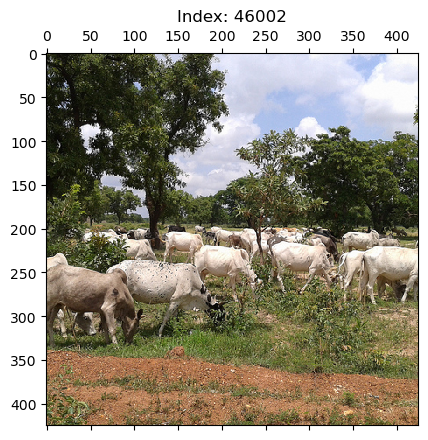

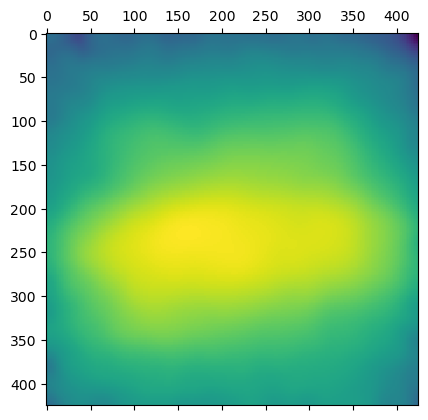

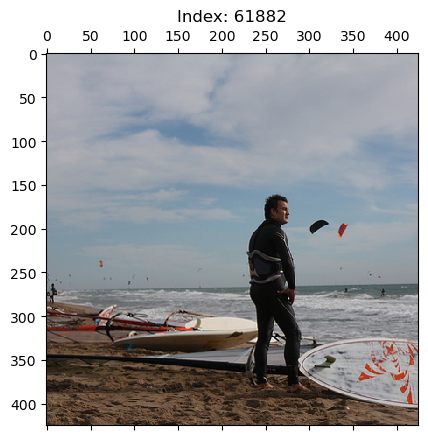

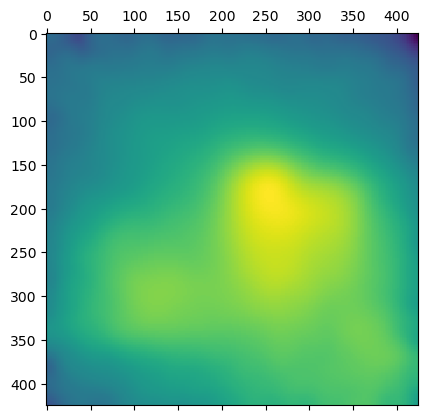

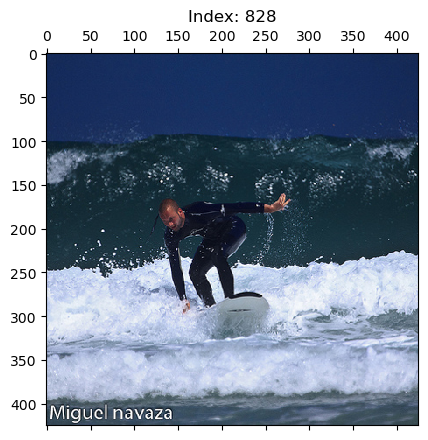

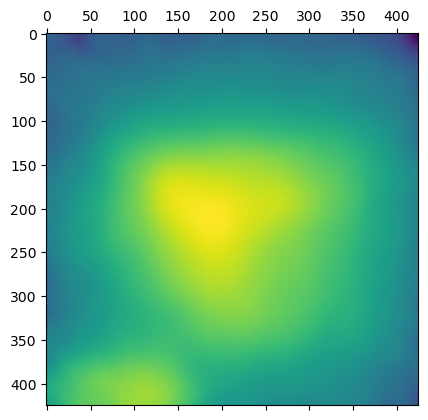

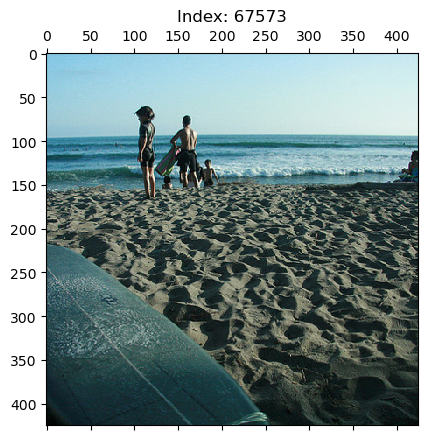

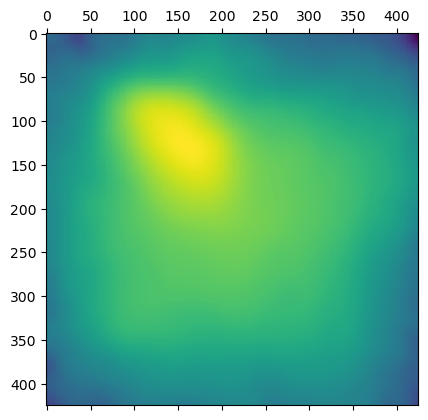

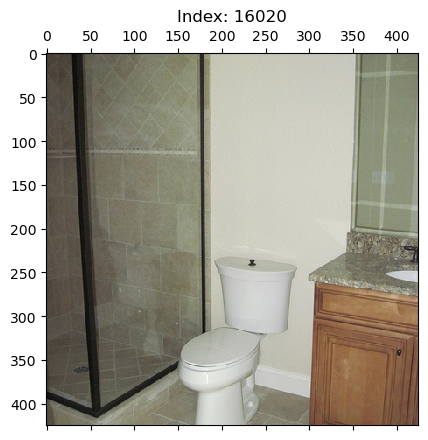

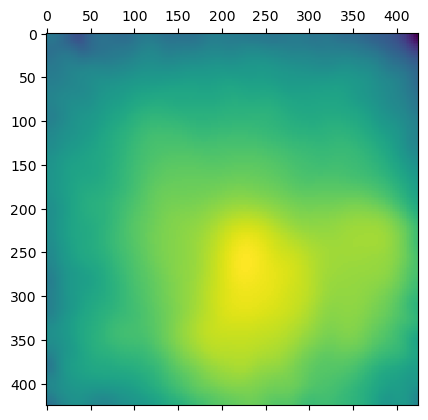

In [54]:
for idx in img_indices[:5]: 
    print(idx)
    image = image_data_73k[idx] 
    plt.matshow(image_data_73k[idx])
    plt.title(f"Index: {idx}")
    sal_map = gen_saliency(image,model,channel_loc = 2)
    plt.matshow(sal_map.detach().cpu().numpy()[0,0])
    print(sal_map.shape) 

In [56]:
DEVICE = 'cuda'
model.to(DEVICE);

In [59]:
def gen_S_matrix():
    
    num_pixels = 425
    batch_size = 32
    S_mat_full = np.ones([1,num_pixels*num_pixels])
    
    for idx in tqdm(img_indices): 
        
        image = image_data_73k[idx]         
        sal_map = gen_saliency(image,model,channel_loc = 2)[0,0]
        sal_map = sal_map.cpu().detach().numpy().reshape(-1 , num_pixels * num_pixels) # [1, 180625]
                
        S_mat_full =np.vstack((S_mat_full,sal_map))  
        
    return S_mat_full

In [60]:
def gen_saliency_batch(image,model,channel_loc = 0):
    '''
    Generate saliency map using DeepGaze for mutple batches at once, if the input images are in batches 
    
    '''
    model = model 

    centerbias_template = np.load('../src/DeepGaze/centerbias_mit1003.npy')
    
    # Here Image is supposed to be [H x W x C] 
    # But NSD images are [C x H x W] 
        
    if channel_loc == 0:
        centerbias = zoom(centerbias_template, (image.shape[1]/centerbias_template.shape[0], image.shape[2]/centerbias_template.shape[1]), order=0, mode='nearest')
        image_tensor = torch.tensor(image).to(DEVICE)

    elif channel_loc == 2: 
        centerbias = zoom(centerbias_template, (image.shape[1]/centerbias_template.shape[0], image.shape[2]/centerbias_template.shape[1]), order=0, mode='nearest')
        image_tensor = torch.tensor(image.transpose(0,3,1,2)).to(DEVICE) # for the face example

    centerbias -= logsumexp(centerbias)
    
    # create image tensor with H x W x C dimensions 
    # if the image is of the shape [W x H x C] --> H x W x C     
    centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)
    log_density_prediction = model(image_tensor, centerbias_tensor)

    return log_density_prediction 

In [61]:
test_image = image_data_73k[:2] #(2, 425, 425, 3)
image_face = face()


image_tensor = torch.tensor(test_image.transpose(0,3,1,2)) # torch.Size([2, 3, 425, 425])

print(image_face.shape,"-->",image_face.transpose(2, 0, 1).shape)
print(image_tensor.shape)

(768, 1024, 3) --> (3, 768, 1024)
torch.Size([2, 3, 425, 425])


In [137]:
# sal_maps = gen_saliency_batch(test_image,model,2)

(425, 425) torch.Size([1, 425, 425])
torch.Size([2, 3, 425, 425])
torch.Size([2, 1, 425, 425])


In [163]:
# sal_maps[:,0].shape

torch.Size([2, 425, 425])

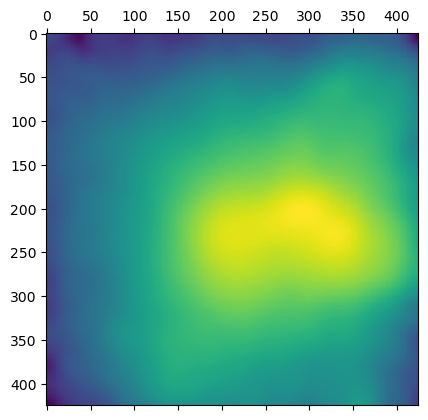

In [168]:
# try reshaping and unshaping back to retrive the maps back 
sal_maps_big = sal_maps[:,0]

sal_maps_big = sal_maps.reshape(sal_maps.shape[0],-1)

plt.matshow(sal_maps_big[1].reshape(425,425).detach().numpy())

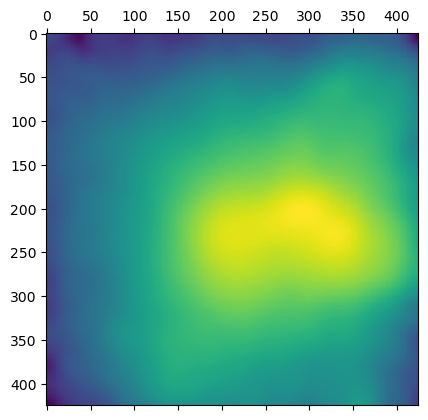

In [176]:
sal_maps[:,0].shape

a = torch.randn((5,425,425))

b = torch.cat((a,sal_maps[:,0]),0)

plt.matshow(b[6].reshape(425,425).detach().numpy())

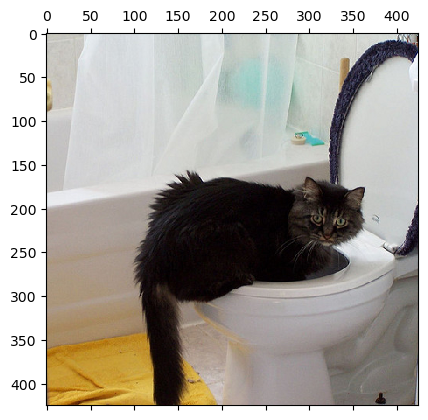

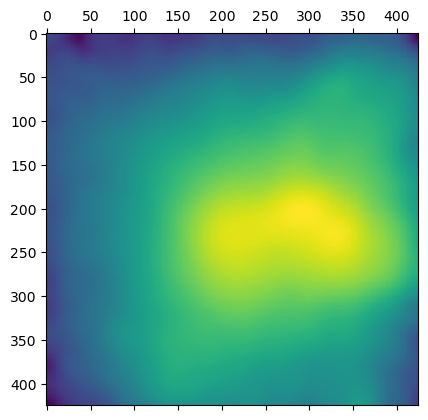

In [161]:
plt.matshow(sal_maps[1,0].detach().numpy())

In [ ]:
S_mat = gen_S_matrix()

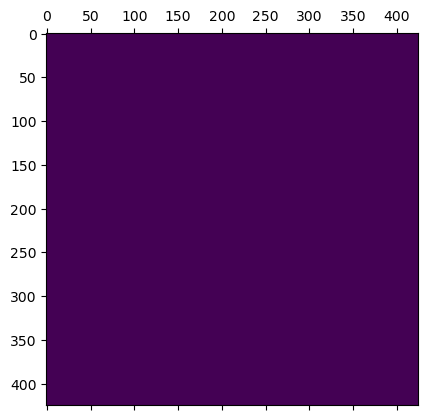

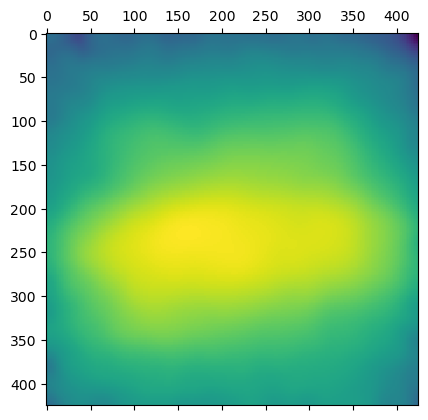

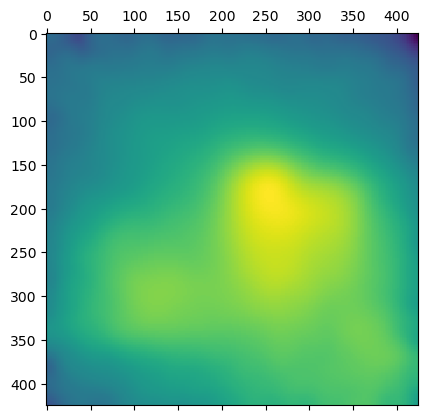

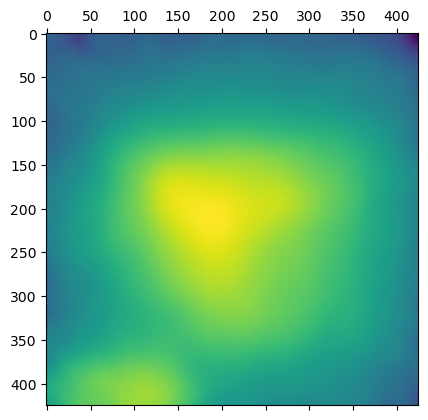

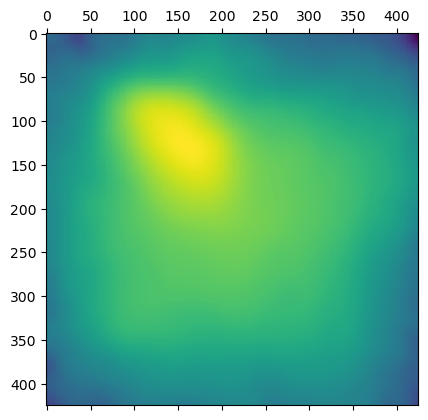

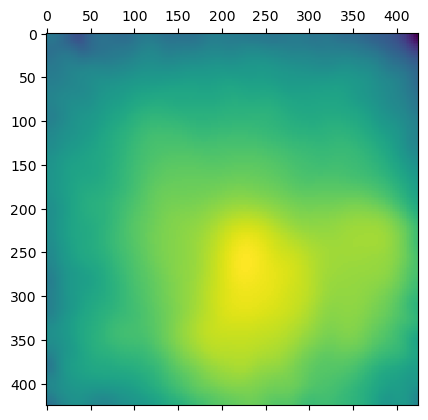

In [85]:
for idx in range(S_mat.shape[0]):
    smap = S_mat[idx,:].reshape(425,425)
    plt.matshow(smap)

In [ ]:
S_mat_full = gen_S_matrix()

In [62]:
def gen_S_matrix_batched(batch_size = 8):
    
    num_pixels = 425
    batch_size = batch_size    
    
    S_mat_full = torch.ones((1,num_pixels,num_pixels))
    
    for indices in tqdm(range(0,len(img_indices), batch_size)):
        chunk = img_indices[indices:indices+batch_size]
        images = image_data_73k[chunk] # [32 x 425 x 425 x 3] 
        
        
        sal_maps = gen_saliency_batch(images,model,channel_loc = 2)[:,0].detach().cpu() # 32, 425, 425
        
        S_mat_full = torch.cat((S_mat_full.cpu(), sal_maps), dim = 0) 
        # Can reshape later, now can just concatenate the matrices together
        # sal_maps_big = sal_maps.reshape(sal_maps.shape[0],-1)
    return S_mat_full

In [63]:
S_mat_full_batched = gen_S_matrix_batched()

100%|██████████| 3750/3750 [1:41:29<00:00,  1.62s/it]


In [64]:
np.save(DATA_PATH+"/S_mat_full_batched.npy",S_mat_full_batched)

In [65]:
S_mat_full_batched.shape

torch.Size([30001, 425, 425])

In [85]:
# Clear garbage collector in case of CUDA memory issue
import gc
gc.collect()
torch.cuda.empty_cache()
